In [1206]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import scipy.stats as stats

#from mpltools import special ##leon

# for 3d plot
#import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import cm
#from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn-poster')

# DEFINE DATA CLASS
class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp # 1 (default time?)
        self.keytime=keytime # 2 +Time.deltaTime
        self.ttime=ttime # 3 Time.time
        self.keypress=keypress # 4
        self.targetid=targetid # 5
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx # 11
        self.hmd_ry=hmd_ry # 12
        self.hmd_rz=hmd_rz # 13

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime


class User(object):
    def __init__(self, lat, lon, user, test):
        self.lat=lat
        self.lon=lon
        self.user=user
        self.test=test
        self.speed_array = [[] for x in range(5)]
        self.time_array = [[] for x in range(5)]
        self.speed_raw = [[] for x in range(5)]
        self.time_raw = [[] for x in range(5)]
        self.speed_mean = [[] for x in range(5)]
        self.speed_std = [[] for x in range(5)]
        self.time_mean = [[] for x in range(5)]
        self.time_std = [[] for x in range(5)]
        
        self.time_median = [[] for x in range(5)]
        self.speed_median = [[] for x in range(5)]
        #print(np.array(self.speed_array).shape)
        
        self.round_array = []
        self.round_data = [[] for x in range(5)]
        


        
    ## READ DATA
    def _read_data(self, file):
        raw_data=[]
        print("Reading %s"%file)
        seperator="\t"
        with open(file,"r") as fp:
            for line in fp:
                if line.startswith("Time"):
                    continue     ## Skip the Header
                l=line[:-1]   ## Delete the Last Element then Return
                f=l.split(seperator)   ## Divide the Raw Data to Pieces
                if(int(f[3])==1):   ## 4.When Finish Targeting and Press Key
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
                else: 
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))

        return raw_data



    # Input Raw Data, Each Tester, return aim_time[[[,,,],,,,,][,,,,,][,,,,,]] 3-layer array
    # Every Target Aiming Time in aim_time[lat][lon] = [first, second, third]
    def _aim_time_filter(self, input_raw_data):
        aim_time={}
        filtered_data=[a for a in input_raw_data if a.keypress==1]

        for i in range(len(filtered_data)-1):
            if(filtered_data[i+1].targetid!=filtered_data[i].targetid):
                continue # when resuming back
            if((i <= (len(filtered_data)-3)) and (filtered_data[i-1].targetid==filtered_data[i+2].targetid)):
                continue # when two same targets appear one after one
            delta_time=filtered_data[i+1].ttime-filtered_data[i].ttime
            #print(delta_time, filtered_data[i].targetid)

            key1=str(int(filtered_data[i].target_lat))
            key2=str(int(filtered_data[i].target_lon))
            if(key1 in aim_time)==False:
                aim_time[key1]={}
            if(key2 in aim_time[key1])==False:
                aim_time[key1][key2]=[]

            aim_time[key1][key2].append(TimeData(filtered_data[i].targetid,filtered_data[i].target_lon,filtered_data[i].target_lat,delta_time))

        aim_time[str(0)][str(0)]=[]   # Special (0,0) Not Exist but for data processing, add a pseudo datum
        aim_time[str(0)][str(0)].append(TimeData(float(21),float(0),float(0),float(0)))

        return aim_time   # aim_time is 3*3*7 array{}

    LAT_KEY = ('-30','0','30')
    LON_KEY = ['0','30','60','90','120','150','180']

    def _extract_time(self, input_time):
        #lat = [a for a in input_time]
        #lon = [b for b in input_time[lat]]
        #target = [c.deltatime for c in input_time[lon] ]
        
        time_dict = {}
        #time_flat = [] # not useful, not sorted
        
        lat_order = ['-30','0','30']
        lon_order = ['0','30','60','90','120','150','180']
        
        for lat in lat_order:
            time_dict[lat] ={}
            #time_lon = []
            for lon in lon_order:
                time_dict[lat][lon] = [target.deltatime for target in input_time[lat][lon]]
                #time_target = [target.deltatime for target in input_time[lat][lon]]
                #time_lon.append(time_target)
            #time_flat.append(time_lon)

        return time_dict#, time_flat
    
    def _cal_round(self, input_time_dict, test):
        r=[[],[],[],[]]
        #print(input_time_dict)
        for lat in input_time_dict:
            for lon in input_time_dict[lat]:
                if ((lon=='0') and (lat=='0')):
                    continue
                for i in range(4):
                    #print("lat", lat, "lon", lon, "i", i, "value", input_time_dict[lat][lon][i])
                    if (i >= len(input_time_dict[lat][lon])):
                        print("Round "+str(i+1)+"("+lat+","+lon+" Not Enough Data")
                        r[i].append(input_time_dict[lat][lon][-1])
                    else:
                        r[i].append(input_time_dict[lat][lon][i])
                    

                
        self.round_array = [np.sum(r[0]), np.sum(r[1]), np.sum(r[2]), np.sum(r[3])]
        
        #print(round_array)
        if (False):
            fig,ax=plt.subplots()
            width = 0.6
            plt.bar(range(4), self.round_array, width, label='Round Time', color="G")
            plt.title('Test '+ str(test))
            ax = plt.gca()
            ax.yaxis.grid(True, linestyle = "--")      
            plt.show()
        
        return self.round_array

    def _flatten_data(self, input_data):
        
        flat_data = []
        
        for lat in input_data:
            data_lon = []
            for lon in input_data[lat]:
                data_target = [target for target in input_data[lat][lon]]
                data_lon.append(data_target)
            flat_data.append(data_lon)
        
        return flat_data
    
    def _time_to_speed(self, input_time):
        
        speed={}
        
        for lat in input_time:
            speed[lat]={}
            for lon in input_time[lat]:
                speed[lat][lon]=[]
                for target in range(len(input_time[lat][lon])):
                    if (input_time[lat][lon][target]==0):
                        #r.append(0) # speed = 0
                        speed[lat][lon].append(0)
                        continue
                    
                    angle = User._angle_ac(self, int(lat), int(lon))
                    speed[lat][lon].append( angle / input_time[lat][lon][target] )

        return speed    # 3*3*7 array{}

    def _angle_ap(self, lat, lon):
        angle = math.sqrt( lat**2 + lon**2 )
        return angle

    def _angle_ac(self, lat, lon):
        angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
        return angle

    # Calculate the Mean and STD
    def _dict_stat(input_dict): # return

        key1=['-30','0','30']    # 3 lat
        if (len(input_dict) == 1):
            key1=['0']    # 1 lat
        key2=[0,30,60,90,120,150,180]
        
        #key3= [lat for lat in input_dict]
        #key4= [lon for lon in input_dict[key3[0]]]
        key3 = input_dict.keys()
        key4 = input_dict['0'].keys()
    
        if (tuple(input_dict.keys()) != User.LAT_KEY):
            print('Error may happen')
        
        target_mean={}
        target_std={}
        for lat in input_dict:
            target_mean[lat]={}
            target_std[lat]={}
            for lon in input_dict[lat]:
                if(input_dict[lat][lon]==[0]):
                #if(k2==0):
                    target_mean[lat][lon]=0
                    target_std[lat][lon]=0
                    continue
                
                target_mean[lat][lon]=np.mean(input_dict[lat][lon])
                target_std[lat][lon]=np.std(input_dict[lat][lon])

        return target_mean, target_std    # 3*7 array[]

    def _list_stat(input_data): # return
        
        #print(np.array(input_data).shape)
            
        target_mean=[]
        target_std=[]
        target_median=[]
        
        #for lon in range(len(input_data)):
        for lat in range(3):
            mean=[]
            std=[]
            median=[]
            #for lat in range(len(input_data[lon])):
            for lon in range(7):
                #if(lon==1 and lat==0):
                #if(k2==0):
                if (input_data[lat][lon] == [0]):
                    mean.append(0)
                    std.append(0)
                    median.append(0)
                    continue
                data = [target for target in input_data[lat][lon]]
                mean.append(np.mean(data))
                std.append(np.std(data))
                
                #data.sort();
                #if (len(data)>2):
                #    median.append(np.mean(data[1:-1]))
                #elif (len(data)==2):
                #    median.append((data[0]+data[1])*0.5)
                #else:
                #    median.append(data[0])
                median.append(np.median(data))
                        
    
            target_mean.append(mean)
            target_std.append(std)
            target_median.append(median)

        return target_mean, target_std, target_median    # 3*7 array[]


    def add_test(self, test, file):
        raw_data = User._read_data(self, file)
        aim_time = User._aim_time_filter(self, raw_data)
        time_dict = User._extract_time(self, aim_time)
        
        self.round_data[test-1] = User._cal_round(self, time_dict, test)##
        
        time_flat = User._flatten_data(self, time_dict)
        speed_dict = User._time_to_speed(self, time_dict)
        speed_flat = User._flatten_data(self, speed_dict)
        
        #self.speed_array.append(np.array(speed_flat))
        self.time_array[test-1] = time_flat
        self.speed_array[test-1] = speed_flat
        #self.time_raw.append(time_dict)
        self.time_raw[test-1] = time_dict
        self.speed_raw[test-1] = speed_dict
        
        #### mean or median here
        
        self.time_mean[test-1], self.time_std[test-1], self.time_median[test-1] = User._list_stat(time_flat)
        self.speed_mean[test-1], self.speed_std[test-1], self.speed_median[test-1] = User._list_stat(speed_flat)
        
        #self.time_mean = User._dict_stat
    
    def dict_print(dict_to_print):
        for x in dict_to_print:
            print ('--', x, '--')
            for y in dict_to_print[x]:
                print (y,':', dict_to_print[x][y])
                
    #def _mean(self, array):
    
    def cal_ratio(before, after):
        
        ratio=[]
        log=[]
        
        for i in range(len(before)):
            r=[]
            l=[]
            #print(len(before[i]))
            for j in range(len(before[i])):
                if(after[i][j]==0):
                    r.append(1) #ratio
                    l.append(0) #log
                    continue
                r.append( after[i][j] / before[i][j] ) #ratio
                l.append( math.log2( after[i][j] / before[i][j] ) ) #log
                #print(i,j,mean_after[i][j],mean_before[i][j])
            ratio.append(r)
            log.append(l)
            
        #print(np.array(ratio).shape)
        #print(np.array(log).shape)
        return ratio,log
    
    def ratio_of(self, data_type, average_type, before, after):
        if (data_type == 'time'):
            if (average_type == 'mean'):
                data_before = self.time_mean[before-1]
                data_after = self.time_mean[after-1]
            if (average_type == 'median'):
                data_before = self.time_median[before-1]
                data_after = self.time_median[after-1]
                
        if (data_type == 'speed'):
            if (average_type == 'mean'):
                data_before = self.speed_mean[before-1]
                data_after = self.speed_mean[after-1]
            if (average_type == 'median'):
                data_before = self.speed_median[before-1]
                data_after = self.speed_median[after-1]
            
        
        #print(np.array(self.speed_mean).shape)
        
        #print(np.array(self.speed_mean[before-1]).shape, np.array(data_before).shape)
        ratio, log = User.cal_ratio(data_before, data_after)
        return ratio, log
            
        
        
        
        




class Exp(object):
    def __init__(self, _test_order, _user_order, _lat, _lon):
        self._test_order=_test_order
        self.lat=_lat
        self.lon=_lon
        self.user_order = _user_order
        
        self.time_mean_10x3x7 = [] #10*3*7
        self.time_mean_3x7x10 = [] #3*7*10
        self.time_mean_3x7 = [] #3*7
        self.time_std_3x7 = []
        self.time_std_3x7 = []
        self.time_mean_lon = [] #7
        self.time_mean_lat = [] #3
        self.time_mean_overall = 0 #1
        
        self.time_median_10x3x7 = [] #10*3*7
        
        self.speed_mean_10x3x7 = [] #10*3*7
        self.speed_mean_3x7x10 = [] #3*7*10
        self.speed_mean_3x7 = [] #3*7
        self.speed_std_3x7 = []
        self.speed_mean_lon = [] #7
        self.speed_mean_lat = [] #3
        self.speed_mean_overall = 0 #1
        
        self.speed_median_10x3x7 = [] #10*3*7
        
        self.no_user=True
        
        self.round_10x4 = []
        
        
        
    def add_user(self, temp_user):
        #print('temp_user.time_array',temp_user.time_array[self._test_order-1])
        #print('self.data_group',np.array(self.data_group))
        self.time_mean_10x3x7.append(temp_user.time_mean[self._test_order-1])
        self.time_median_10x3x7.append(temp_user.time_median[self._test_order-1])
        
        self.speed_mean_10x3x7.append(temp_user.speed_mean[self._test_order-1])
        self.speed_median_10x3x7.append(temp_user.speed_median[self._test_order-1])
        
        self.round_10x4.append(temp_user.round_data[self._test_order-1])
    
    
    def _deform(input_data):
        result=[]
        for lat in range(3):
            r=[]
            for lon in range(7):
                all_user=[]
                for user in range(len(input_data)):
                    all_user.append(input_data[user][lat][lon])
                r.append(all_user)
            result.append(r)
        
        return result
    
    
    def _cal_mean_3x7(input_data):
        mean=[]
        std=[]
        for lat in range(3):
            m=[]
            s=[]
            for lon in range(7):
                all_user=[]
                for user in range(len(input_data)):
                    all_user.append(input_data[user][lat][lon])
                m.append(np.mean(all_user)) # *7
                s.append(np.std(all_user))
            mean.append(m)
            std.append(s)# *3
            
        return mean, std
    
    
    def _cal_mean_1(input_data):
        #print(np.array(input_data))
        data = [i for i in np.array(input_data).flatten() if (i!=0)]
        #print(np.array(input_data).flatten())
        #mean = np.mean(np.delete(np.array(input_data), 7))
        #std = np.std(np.delete(np.array(input_data), 7))
        mean = np.mean(data)
        std = np.std(data)
            
        return mean
    
    
    def cal_mean_3_old(input_data): # input 3*7
        mean = [np.mean(input_data[i]) for i in range(len(input_data))]
        mean[1] = np.mean(input_data[1][1:]) # lat=0
        
        std = [np.std(input_data[i]) for i in range(len(input_data))]
        std[1] = np.std(input_data[1][1:]) # lat=0
        
        return mean, std
    
    def cal_mean_3(input_data): # input 10*3*7
        mean=[]
        std=[]
        for lat in range(3):
            data=[]
            
            for user in range(len(input_data)):  
                for lon in range(7):
                    if (input_data[user][lat][lon] == 0):
                        continue
                    data.append(input_data[user][lat][lon])
                    
            mean.append(np.mean(data)) 
            std.append(np.std(data))
        
        return mean, std
    
    
    def cal_mean_7_old(input_data_raw): # input 3*7
        input_data = np.array(input_data_raw).T
        mean = [np.mean(input_data[i]) for i in range(len(input_data))]
        mean[0] = np.mean([input_data[0][0],input_data[0][2]]) # lon=0
        
        std = [np.std(input_data[i]) for i in range(len(input_data))]
        std[1] = np.std([input_data[0][0],input_data[0][2]])# lat=0
        
        return mean, std
    
    def cal_mean_7(input_data): # input 10*3*7
        mean=[]
        std=[]
        #for lat in range(3):
        for lon in range(7):
            data=[]
            
            for user in range(len(input_data)):  
                #for lon in range(7):
                for lat in range(3):
                    if (input_data[user][lat][lon] == 0):
                        continue
                    data.append(input_data[user][lat][lon])
                    
            mean.append(np.mean(data)) 
            std.append(np.std(data))
        
        return mean, std
        
    
    def cal_mean(self):
        self.time_mean_3x7, self.time_std_3x7 = Exp._cal_mean_3x7(self.time_median_10x3x7)  #####median/mean
        self.time_mean_overall = Exp._cal_mean_1(self.time_median_10x3x7)                  #####median/mean
        
        self.speed_mean_3x7, self.speed_std_3x7 = Exp._cal_mean_3x7(self.speed_mean_10x3x7) #####median/mean
        self.speed_mean_overall = Exp._cal_mean_1(self.speed_mean_10x3x7)

        #self.time_mean_overall = np.mean(np.delete(np.array(self.time_mean_3x7), 7))
        #std
        #self.speed_mean_overall = np.mean(np.delete(np.array(self.speed_mean_3x7), 7))
        
        #self.time_mean_lat = [np.mean(self.time_mean_3x7[i]) for i in range(len(self.time_mean_3x7))]
        #self.time_mean_lat[1] = np.mean(self.time_mean_3x7[1][1:]) # lat=0
        #temp = np.transpose(self.time_mean_3x7)
        #self.time_mean_lon = [np.mean(temp[i]) for i in range(len(temp))]
        #self.time_mean_lon[0] = np.mean([temp[0][0],temp[0][2]]) # lon=0


In [1207]:
def plot_single_user(which_type, input_data):
    
    data = input_data
    lon_key = [a for a in User.LON_KEY]
    lon_key.pop(0)
    
    data_short = [a for a in data[1]]
    data_short.pop(0)
    plt.plot()
    
    plt.plot(User.LON_KEY, data[0], '-v', label="-30")
    plt.plot(lon_key, data_short, '-o', label="0")
    plt.plot(User.LON_KEY, data[2], '-^', label="30")
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_axisbelow(True)
    
    if (which_type=='ratio'):
        plt.ylim(0,2)
        ax.set_title('Ratio')
        plt.ylabel('Ratio Value')
    if (which_type=='log'):
        plt.ylim(-1,1)
        ax.set_title('Log')
        plt.ylabel('Log Value')
    
    plt.legend(title="Latitude")
    #plt.ylabel(kind2 + kind1)
    plt.xlabel('Target Longitude')
    plt.show()
    
    
def plot_3d(data):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    #X = range(3)
    #Y = range(6)
    #Z = data.speed_mean[0][X][Y]
    
    # as plot_surface needs 2D arrays as input
    #x = np.arange(10)
    y = [-30,0,30]
    #y = np.array(range(10,15))
    x = [0,30,60,90,120,150,180]
    # we make a meshgrid from the x,y data
    X, Y = np.meshgrid(x, y)
    #Z = np.sin(np.sqrt(X**2 + Y**2))
    Z = np.array(data.speed_mean[0])
    #X = np.arange(-5, 5, 0.25)
    #Y = np.arange(-5, 5, 0.25)
    #X, Y = np.meshgrid(X, Y)
    #R = np.sqrt(X**2 + Y**2)
    #Z = np.sin(R)
    #surf = ax.plot_surface(X, Y, Z, alpha=1)
    #ax.plot_wireframe(X, Y, Z, alpha=1)
    
    #cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='y', offset=30, cmap=cm.coolwarm)
    
    print(np.array(data.speed_mean[0]).shape)
    print(X)
    print(Y)
    print(Z.flatten())
    
    width = depth = 10
    bottom = np.zeros(21)
    print(bottom)
    ax.bar3d(X.flatten(), Y.flatten(), bottom, width, depth, Z.flatten(), shade=True)
    #ax.set_title('Shaded')
    
    plt.xticks(x,x)
    plt.yticks(y,y)

    
    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)
    for ix in range(3):
        for iy in range(7):
            ax.scatter(float(User.LON_KEY[iy]), float(User.LAT_KEY[ix]), data.speed_mean[0][ix][iy], c='r', marker='o')

    plt.show()


def plot_img(data):
    y = [-30,0,30]
    x = [0,30,60,90,120,150,180]

    fig, ax = plt.subplots()
    Z = np.array(data)
    im = ax.imshow(Z, cmap=cm.gray)
    #interpolation='bicubic'
    
    plt.xticks(range(len(x)),x)
    plt.yticks(range(len(y)),y)
    
    plt.show()

def plot_bar(mean_1, mean_2, input_std_1=None, input_std_2=None):
    
    if (np.array(mean_1).shape == (3,7)):
        key1=[-30, 0, 30]
        key2=[0, 30, 60, 90, 120, 150, 180]
    
    elif (np.array(mean_1).shape == (7,3)):
        key1=[0, 30, 60, 90, 120, 150, 180]
        key2=[-30, 0, 30]
        
    elif (np.array(mean_1).shape == (3,)):
        key1=[-30, 0, 30]
        key2=[]
        
    elif (np.array(mean_1).shape == (7,)):      
        key1=[0, 30, 60, 90, 120, 150, 180]
        key2=[]
    
    elif (np.array(mean_1).shape == ()):
        key1=[]
        key2=[]
    
    else:
        print("Error???")
        key1=[]
        key2=[]
        
    if ( (input_std_1 is None) and (input_std_2 is None) ):   
        std_1=np.zeros_like[mean_1]
        std_2=np.zeros_like[mean_2]
    else:
        std_1=input_std_1
        std_2=input_std_2  
        
    ratio, log = User.cal_ratio(mean_1, mean_2)
    ##########
    print('#####')
    print(np.array(ratio))
    print(np.array(log))
    print('#####')
    #########    
    plt.figure(1, figsize = (12,16))
    
    fig1, ax1 = plt.subplots()
    
    #plt.subplot(2, 1, 1)
    #ax = plt.gca()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    
    width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = key1[k1] + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x , mean_1[k1][k2], width, #label=str(key2[k2]
                    color="C0", alpha=1-opacity*k2, yerr=std_1[k1][k2])
            plt.bar(x + offset , mean_2[k1][k2], width,
                    color="C3", alpha=1-opacity*k2, yerr=std_2[k1][k2])
            
            x_axis.append(x+0.5*offset)
            #x_label.append('('+str(key1[k1])+','+str(key2[k2])+')')
            x_label.append((key1[k1],key2[k2]))
    
    plt.bar(0,0, label="test1", color="C0")
    plt.bar(0,0, label="test2", color="C3")
        
    ax1 = plt.gca()
    ax1.yaxis.grid(True, linestyle = "--")
    
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    
    plt.xticks(x_axis, x_label, rotation=90)
    
    fig2, ax2 = plt.subplots()
    
    #if (np.array(mean_1).shape == (3,7)):
    if (False):
        
        #for k1 in range(len(key1)):
        #    for k2 in range(len(key2)):


        lon_key = [a for a in User.LON_KEY]
        lon_key.pop(0)

        data_1_short = [a for a in mean_1[1]]
        data_1_short.pop(0)

        data_2_short = [a for a in mean_2[1]]
        data_2_short.pop(0)

        plt.plot(User.LON_KEY, mean_1[0], ':v', color = 'C1', label="-30")
        plt.plot(lon_key, data_1_short, ':o', color = 'C2', label="0")
        plt.plot(User.LON_KEY, mean_1[2], ':^', color = 'C3', label="30")

        plt.plot(User.LON_KEY, mean_2[0], '-v', color = 'C1', label="-30")
        plt.plot(lon_key, data_2_short, '-o', color = 'C2', label="0")
        plt.plot(User.LON_KEY, mean_2[2], '-^', color = 'C3', label="30")

    #if (np.array(mean_1).shape == (7,3)):
    
    for k1 in range(len(key1)):
        if (0 in mean_1[k1]):
            data_1= list(mean_1[k1])[:]
            data_2= list(mean_2[k1])[:]
            data_1.remove(0.)
            data_2.remove(0.)
            kkey = key2[:]
            kkey.remove(0)

            plt.plot(kkey, data_1, ':o', color = 'C'+ str(k1), label=str(key1[k1]))
            plt.plot(kkey, data_2, '-o', color = 'C'+ str(k1), label=str(key1[k1]))
        else:
            plt.plot(key2, mean_1[k1], ':o', color = 'C'+ str(k1), label=str(key1[k1]))
            plt.plot(key2, mean_2[k1], '-o', color = 'C'+ str(k1), label=str(key1[k1]))
        
        
        
    ax2 = plt.gca()
    ax2.yaxis.grid(True, linestyle = "--")
    ax2.legend(title="Longitude")
    ax2.set_xlabel('Target Latitude')
    plt.xticks(key2, key2)
    plt.xlim(key2[0]-30, key2[-1]+30)
    
    
    if (len(key1)<5):
        for k1 in range(len(key1)):
            fig,ax=plt.subplots()
            if (0 in mean_1[k1]):
                data_1= list(mean_1[k1])[:]
                data_2= list(mean_2[k1])[:]
                data_1.remove(0.)
                data_2.remove(0.)
                kkey = key2[:]
                kkey.remove(0)

                plt.plot(kkey, data_1, ':o', color = 'C'+ str(k1), label=str(key1[k1]))
                plt.plot(kkey, data_2, '-o', color = 'C'+ str(k1), label=str(key1[k1]))
            else:
                plt.plot(key2, mean_1[k1], ':o', color = 'C'+ str(k1), label=str(key1[k1]))
                plt.plot(key2, mean_2[k1], '-o', color = 'C'+ str(k1), label=str(key1[k1]))

            ax = plt.gca()
            ax.yaxis.grid(True, linestyle = "--")
            ax.legend(title="Longitude")
            ax.set_xlabel('Target Latitude')
            plt.xticks(key2, key2)
            plt.xlim(key2[0]-30, key2[-1]+30)
            #plt.ylim(0, 80)
        
    #ratio
    
    fig3,ax3=plt.subplots()
    
    for k1 in range(len(key1)):
        if (1 in ratio[k1]):
            data_1= list(ratio[k1])[:]

            data_1.remove(1.)

            kkey = key2[:]
            kkey.remove(0)

            plt.plot(kkey, data_1, '-o', color = 'C'+ str(k1), label=str(key1[k1]))

        else:
            plt.plot(key2, ratio[k1], '-o', color = 'C'+ str(k1), label=str(key1[k1]))
            
            
    ax3 = plt.gca()
    ax3.yaxis.grid(True, linestyle = "--")
    ax3.legend(title="Longitude")
    ax3.set_xlabel('Target Latitude')
    plt.xticks(key2, key2)
    plt.xlim(key2[0]-30, key2[-1]+30)
    plt.ylim(0,2)

            
            
    if (len(key1)<5):
        for k1 in range(len(key1)):
            fig,ax=plt.subplots()
            if (1 in ratio[k1]):
                data_1= list(ratio[k1])[:]
                data_1.remove(1.)
                kkey = key2[:]
                kkey.remove(0)

                plt.plot(kkey, data_1, '-o', color = 'C'+ str(k1), label=str(key1[k1]))
            else:
                plt.plot(key2, ratio[k1], '-o', color = 'C'+ str(k1), label=str(key1[k1]))

            ax = plt.gca()
            ax.yaxis.grid(True, linestyle = "--")
            ax.legend(title="Longitude")
            ax.set_xlabel('Target Latitude')
            plt.xticks(key2, key2)
            plt.xlim(key2[0]-30, key2[-1]+30)
            plt.ylim(0, 2)
    
    
    
    fig5,ax5=plt.subplots()
    
    for k1 in range(len(key1)):
        if (0 in log[k1]):
            data_1= list(log[k1])[:]

            data_1.remove(0.)

            kkey = key2[:]
            kkey.remove(0)

            plt.plot(kkey, data_1, '-o', color = 'C'+ str(k1), label=str(key1[k1]))

        else:
            plt.plot(key2, log[k1], '-o', color = 'C'+ str(k1), label=str(key1[k1]))
            
            
    ax5 = plt.gca()
    ax5.yaxis.grid(True, linestyle = "--")
    ax5.legend(title="Longitude")
    ax5.set_xlabel('Target Latitude')
    ax5.set_ylabel('Log')
    plt.xticks(key2, key2)
    plt.xlim(key2[0]-30, key2[-1]+30)
    plt.ylim(-1, 1)
    
            
    plt.show()

def plot_box(data_1, data_2):
    
    boxplot(allone) #showfliers=False)
    

def plot_bar_single(mean):
    
    key1=[-30, 0, 30]
    key2=[0, 30, 60, 90, 120, 150, 180]

    
    fig, ax = plt.subplots()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    
    width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = key1[k1] + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x , mean[k1][k2], 2*width, #label=str(key2[k2]
                    color="G", alpha=1-opacity*k2)
            
            x_axis.append(x)
            #x_label.append('('+str(key1[k1])+','+str(key2[k2])+')')
            x_label.append((key1[k1],key2[k2]))

    yref1=0.01
    yref2=0.05
    yref3=0.1
    
    plt.axhline(y=yref1,linewidth=1, color='r')
    plt.axhline(y=yref2,linewidth=1, color='r')
    plt.axhline(y=yref3,linewidth=1, color='r')
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_xlabel('Target Latitude')
    ax.legend(title="Longitude")
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    
    plt.xticks(x_axis, x_label, rotation=90)
    
    
    
def plot_test_12(mean_1, mean_2, input_std_1=None, input_std_2=None):
    
    plot_bar(mean_1, mean_2, input_std_1, input_std_2)
    
    

In [1208]:
###################### choose user
users=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]#after 13
#users=[1,2,3,4,5,10,14,6,12,13,11] # remove 7,8,9 with only two round
#users=[1,2,3,4,5,9,10,14,6,12]
#users=[1,2,3,4,5,6,8,9,10,12] #roshan
#users=[14,16,17,18,19,15]
#users=[1,2]
######################


user_all = [] 
test1 = Exp(1,1,1,1)
test2 = Exp(2,1,1,1)

for uid in range(len(users)):
    baseFolder=str(users[uid])
    #idx=[3,4,5]
    test_id=[1,2]

    #baseFolder = "1"
    #raw_data = read_data("../Users/"+baseFolder+"/"+str(idx[0])+".txt")

    user_temp = User(1,1,uid,1)
    #print(user_temp.time_raw[0])
    #print('!')
    for idx in range(len(test_id)):
        user_temp.add_test(test_id[idx],"../Users/"+baseFolder+"/"+str(test_id[idx])+".txt")
    
    test1.add_user(user_temp)
    test2.add_user(user_temp)
    
    #test3.add_user(user_temp)
    #test4.add_user(user_temp)
    #test5.add_user(user_temp)
    
    user_all.append(user_temp)
    #print(np.array(Test1.data_group).shape)
    #print('!')

    
    #User.dict_print(user_all[0].time_raw[0])
    #User.dict_print(user_all[1].time_raw[1])

    #print(np.array(user_all[1].time_mean[0]).shape)
    ratio, log = user_temp.ratio_of('time', 'mean',1,2)
    ratio_med, log_med = user_temp.ratio_of('time', 'median',1,2)
    #print(np.array(ratio).shape)
    
    #####plot_single_user('ratio', ratio)
    #####plot_single_user('ratio', ratio_med)
    print(np.array(ratio).shape)
    #plot_single_user(log)
    
    


array1 = np.array([[1,2],[1,2,3]])
print(array1)




Reading ../Users/1/1.txt
Round 4(0,90 Not Enough Data
Reading ../Users/1/2.txt
(3, 7)
Reading ../Users/2/1.txt
Reading ../Users/2/2.txt
(3, 7)
Reading ../Users/3/1.txt
Reading ../Users/3/2.txt
(3, 7)
Reading ../Users/4/1.txt
Round 4(30,30 Not Enough Data
Reading ../Users/4/2.txt
(3, 7)
Reading ../Users/5/1.txt
Reading ../Users/5/2.txt
Round 4(30,0 Not Enough Data
(3, 7)
Reading ../Users/9/1.txt
Round 3(-30,0 Not Enough Data
Round 4(-30,0 Not Enough Data
Round 4(-30,30 Not Enough Data
Round 4(-30,60 Not Enough Data
Round 3(-30,90 Not Enough Data
Round 4(-30,90 Not Enough Data
Round 3(-30,120 Not Enough Data
Round 4(-30,120 Not Enough Data
Round 3(-30,150 Not Enough Data
Round 4(-30,150 Not Enough Data
Round 3(-30,180 Not Enough Data
Round 4(-30,180 Not Enough Data
Round 3(0,30 Not Enough Data
Round 4(0,30 Not Enough Data
Round 3(0,60 Not Enough Data
Round 4(0,60 Not Enough Data
Round 3(0,90 Not Enough Data
Round 4(0,90 Not Enough Data
Round 4(0,120 Not Enough Data
Round 3(0,150 Not Enou

[[1.45975071 1.89842143 1.98508214 2.13251893 2.61326714 3.57389679
  5.48014143]
 [0.         1.01956821 1.54741429 1.70703821 2.21899643 3.17995714
  4.91231429]
 [1.45521821 1.43338571 2.17874643 2.33334643 2.65550179 3.70727179
  5.07814964]]
[1.45975071 1.89842143 1.98508214 2.13251893 2.61326714 3.57389679
 5.48014143 1.01956821 1.54741429 1.70703821 2.21899643 3.17995714
 4.91231429 1.45521821 1.43338571 2.17874643 2.33334643 2.65550179
 3.70727179 5.07814964]
2.6284993571428577 2.0768618035714277


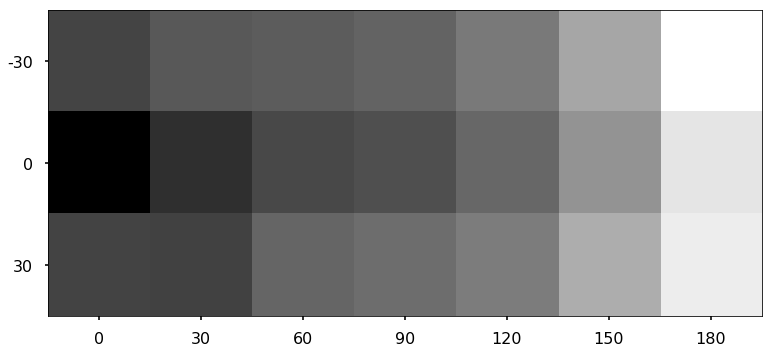

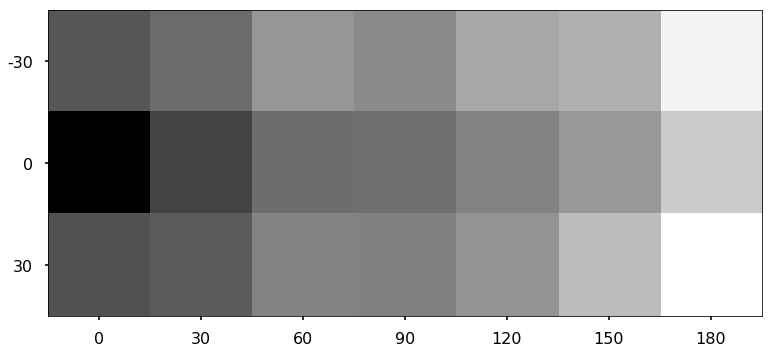

In [1209]:
Exp.cal_mean(test1)
Exp.cal_mean(test2)


#print(np.array(test1.time_mean_group))
print(np.array(test1.time_mean_3x7))
print(np.delete(np.array(test1.time_mean_3x7), 7))
print(test1.time_mean_overall, test2.time_mean_overall)

plot_img(np.array(test1.time_mean_3x7))
plot_img(np.array(test2.time_mean_3x7))

[]
[]
[]
[]
#####
[[0.85533269 0.81653931 1.09322752 0.93804426 0.92827151 0.7153808
  0.64196043]
 [1.         0.96921071 1.02054349 0.94636763 0.84874726 0.69528251
  0.5989029 ]
 [0.81510358 0.91771904 0.86959244 0.80332508 0.80291161 0.74062068
  0.72856452]]
[[-0.22544242 -0.29240576  0.12859368 -0.0922721  -0.10738126 -0.4832167
  -0.63944373]
 [ 0.         -0.04511775  0.02933766 -0.07952736 -0.23659308 -0.5243288
  -0.73960597]
 [-0.2949447  -0.12387556 -0.20158869 -0.31594417 -0.31668692 -0.43319327
  -0.45687136]]
#####


<Figure size 864x1152 with 0 Axes>

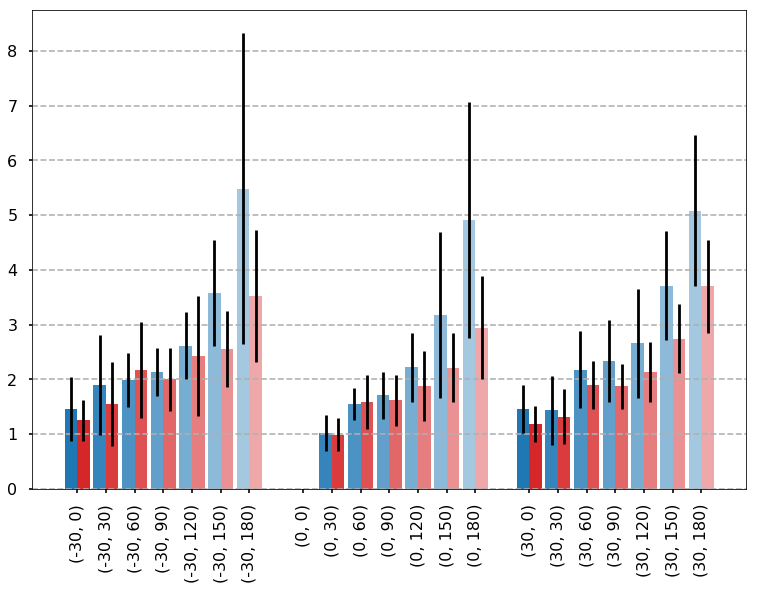

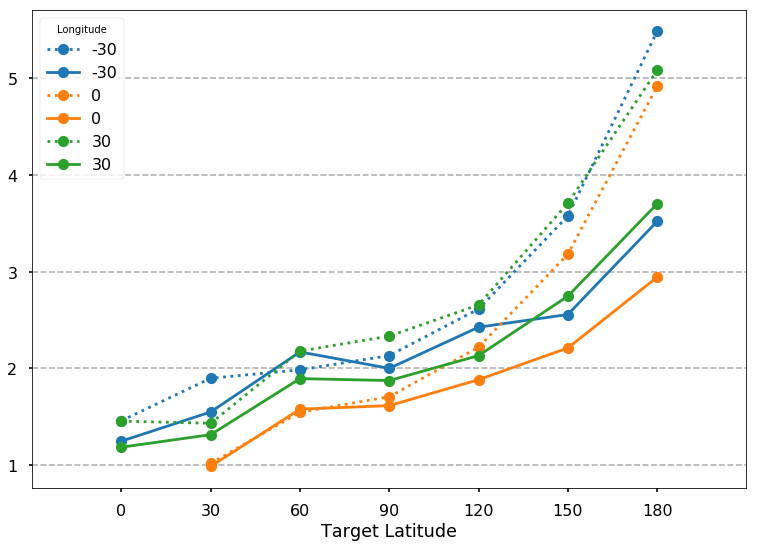

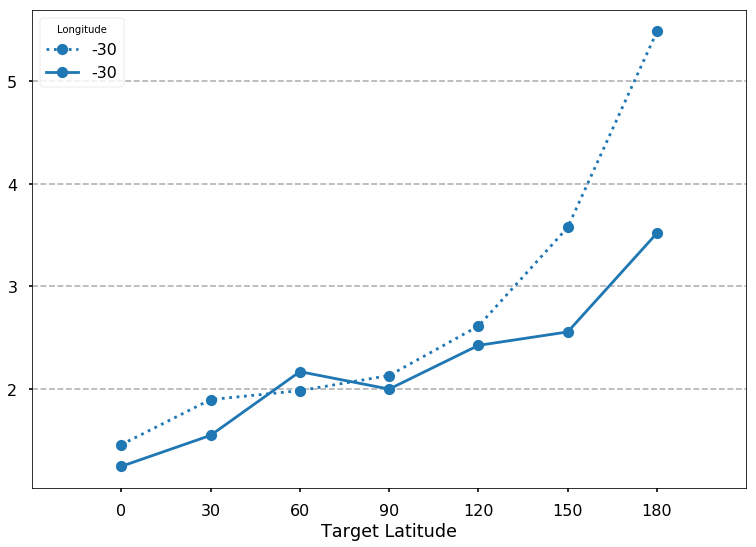

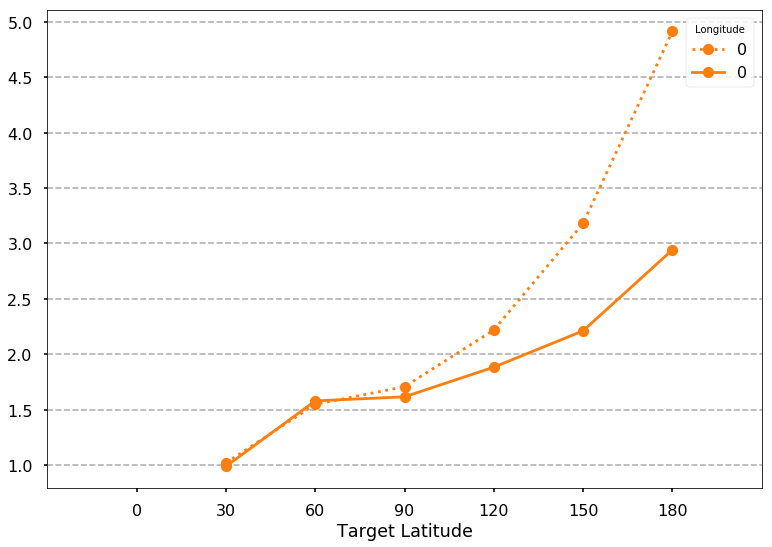

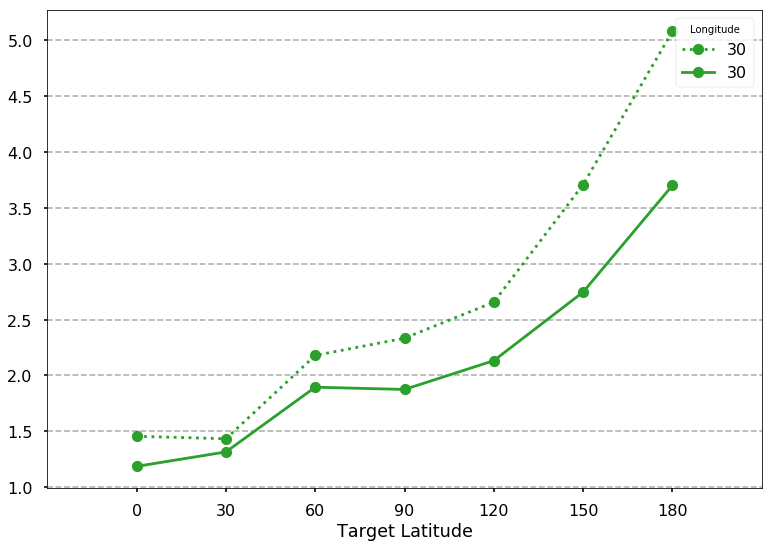

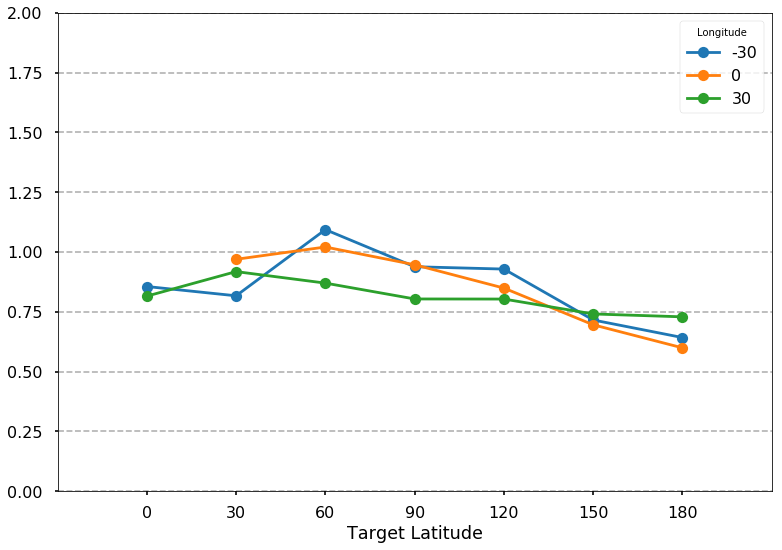

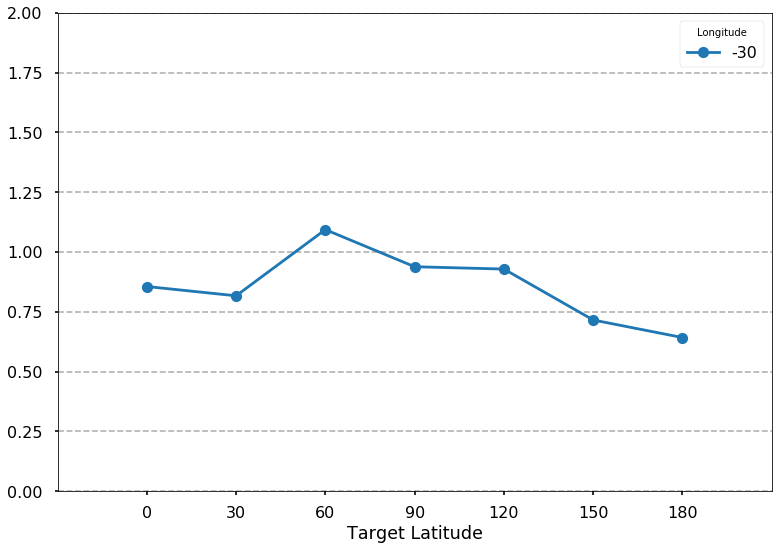

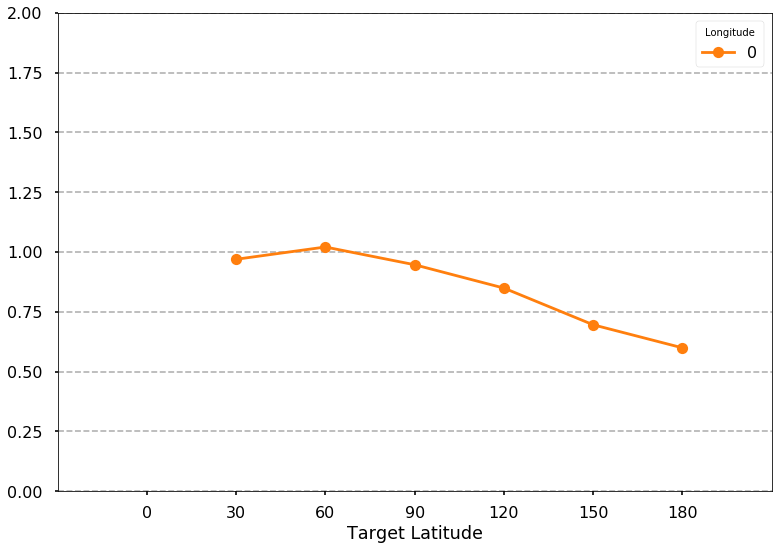

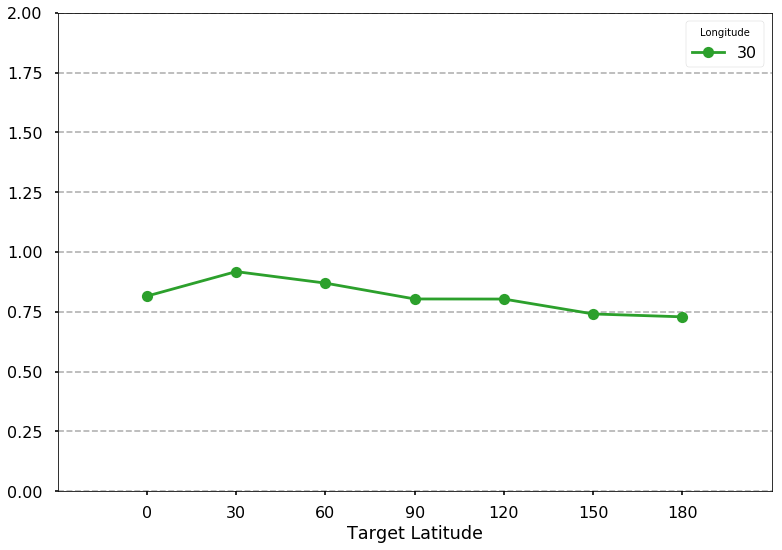

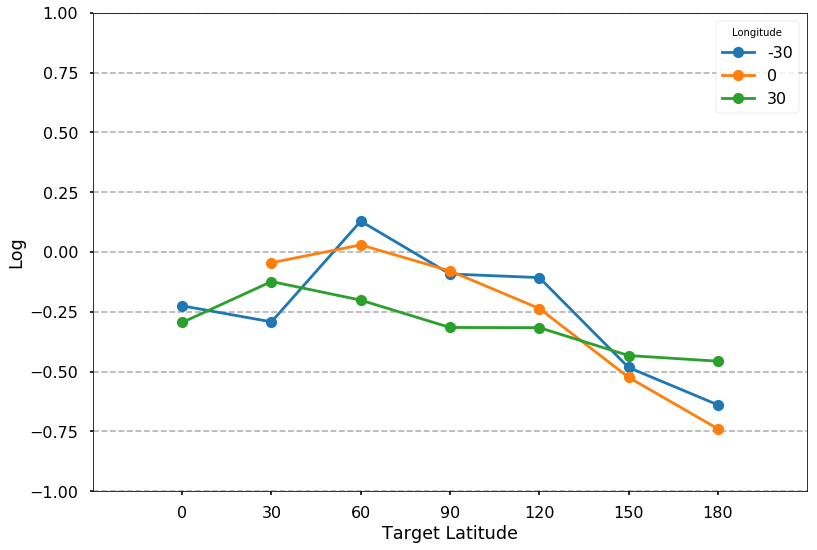

In [1210]:
print(test1.time_mean_lat)
print(test2.time_mean_lat)
print(test1.time_mean_lon)
print(test2.time_mean_lon)

#print(Exp.cal_mean_3_old(test1.time_mean_3x7))
#print(Exp.cal_mean_3(test1.time_mean_10x3x7))
#print(Exp.cal_mean_3(test2.time_mean_10x3x7))

#print(Exp.cal_mean_7_old(test1.time_mean_3x7))
#print(Exp.cal_mean_7(test1.time_mean_10x3x7))
#print(Exp.cal_mean_7(test2.time_mean_10x3x7))

#print(np.array(test1.time_mean_3x7))
#print(np.array(test2.time_mean_3x7))

#plot_bar(test1.speed_mean_3x7, test2.speed_mean_3x7, test1.speed_std_3x7, test2.speed_std_3x7)
plot_bar(test1.time_mean_3x7, test2.time_mean_3x7, test1.time_std_3x7, test2.time_std_3x7)

#plot_bar(np.array(test1.speed_mean_3x7).T, np.array(test2.speed_mean_3x7).T,
#         np.array(test1.speed_std_3x7).T, np.array(test2.speed_std_3x7).T)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


t_all -3.1709367691553076 p_all 0.007368557164812926
[[0.11591496926087799, 0.03872177936485913, 0.7161245538182919, 0.2413292282264688, 0.11559271436748289, 0.008393206831107444, 0.004869822208791413], [nan, 0.4642873171188272, 0.8286049998289535, 0.37973203889159934, 0.028339480016741598, 0.002255038208498275, 0.004073920183908529], [0.03125534301559001, 0.6100973958826086, 0.3457206606870378, 0.0913001752121683, 0.02872790740311104, 0.001997079526389056, 0.0006741357984293228]]
t_all 3.5056851118748047 p_all 0.0038716119005589517


No handles with labels found to put in legend.


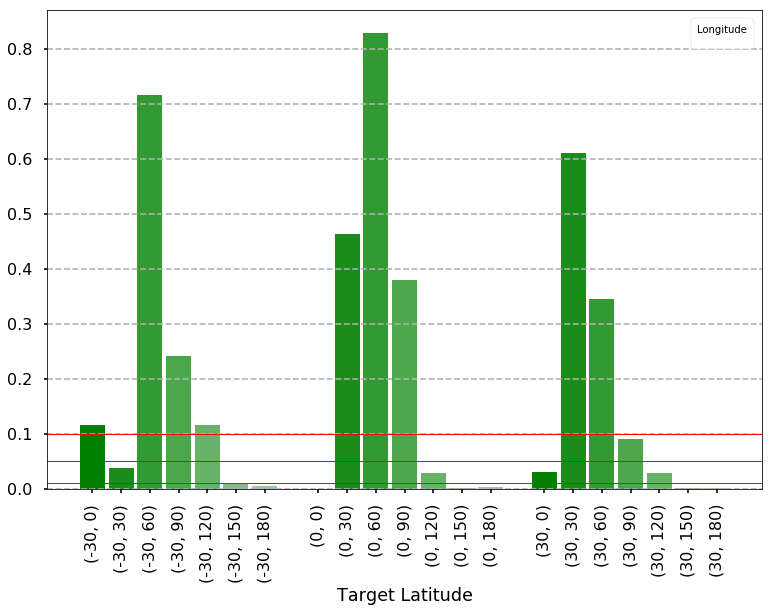

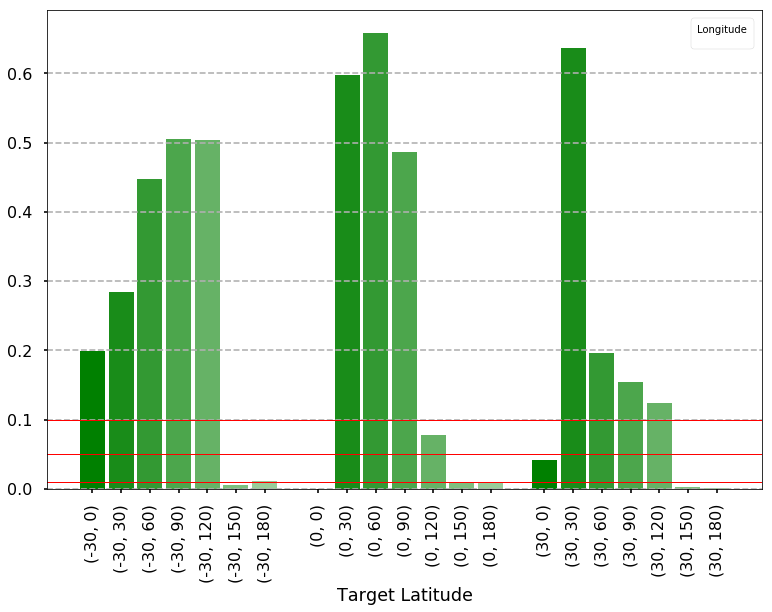

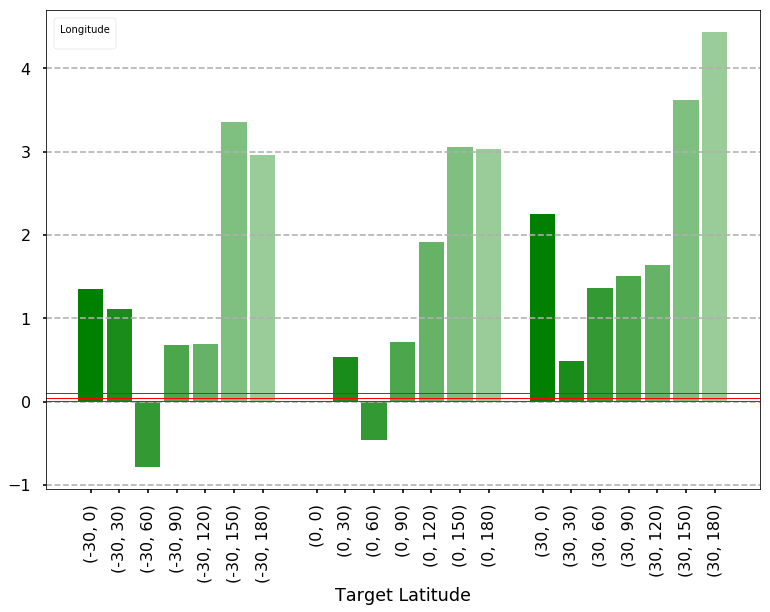

In [1304]:
def cal_ttest(t1, t2):
    tvalue=[]
    pvalue=[]
    for lat in range(3):
        tv=[]
        pv=[]
        for lon in range(7):
            all_user_t1=[]
            all_user_t2=[]
            for user in range(len(t1)):
                all_user_t1.append(t1[user][lat][lon])
                all_user_t2.append(t2[user][lat][lon])

            t,p = ttest_rel(all_user_t1, all_user_t2)
            tv.append(t) # *7
            pv.append(p)
        tvalue.append(tv)
        pvalue.append(pv)# *3
    
    d1 =[]
    d2 =[]
    for user in range(len(t1)):
        data_1 = [i for i in np.array(t1[user]).flat if (i!=0)]
        data_2 = [i for i in np.array(t2[user]).flat if (i!=0)]
        d1.append(np.mean(data_1))
        d2.append(np.mean(data_2))
        
    t_all,p_all = ttest_rel(d1, d2)
    print('t_all', t_all, 'p_all', p_all)
    
    return tvalue, pvalue
    
speed_t, speed_p = cal_ttest(test1.speed_mean_10x3x7, test2.speed_mean_10x3x7)
plot_bar_single(speed_p)

print(speed_p)

time_t, time_p = cal_ttest(test1.time_mean_10x3x7, test2.time_mean_10x3x7)
plot_bar_single(time_p)
plot_bar_single(time_t)
    

##ttest_rel(new_r_1_mean, new_r_2_mean)
Ttest_relResult(statistic=3.4726761207095813, pvalue=0.0041246549228010744)
new_r_mean_ratio_mean 0.8032856050807805
another way 0.7816862247683849
new_r_mean_1/ratio_mean 1.3076009044674204
out [1.]
[[ 39.6462   50.4042   67.0013   49.7457   64.7447   51.8989   40.2445
   55.698    63.01806  40.1431   96.5214   74.5193   66.3049   62.58835]
 [ 51.4913   54.9758   69.3725   45.7563   51.5069   46.9327   40.1633
   46.2265   70.4489   25.2879  110.6468   74.695    52.4098   64.2384 ]
 [ 40.6375   44.8906   58.5236   46.617    51.9133   45.8932   43.3655
   42.5338   56.9879   29.7873   81.612    74.4321   61.0512   63.3781 ]
 [ 42.3292   47.7238   58.1924   46.4395   47.0348   45.8932   41.5892
   43.9447   57.4261   27.5142   63.9021   74.4321   53.1601   63.3781 ]]
[[42.1769  37.5728  54.766   39.784   44.9943  37.9835  46.75082 37.6313
  61.9366  25.75579 34.9279  66.6196  50.91366 36.91899]
 [44.444   37.8375  47.3085  42.3302  45.089   24.591

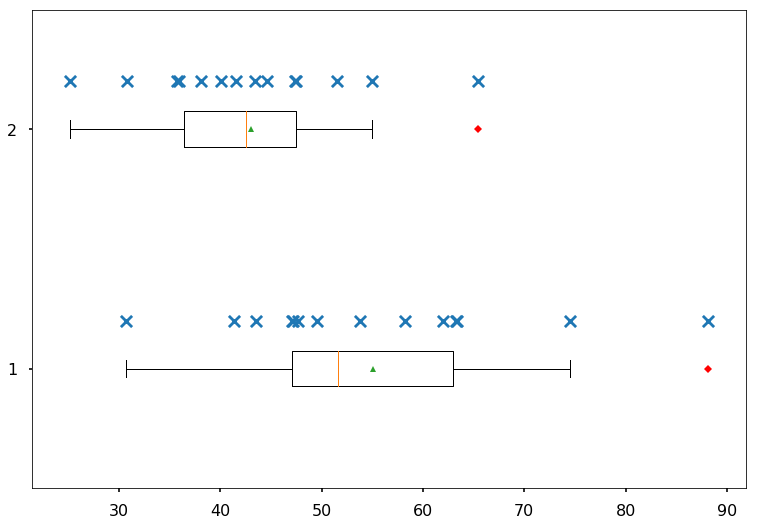

In [1309]:
new_r_1 = np.array(test1.round_10x4).T
new_r_2 = np.array(test2.round_10x4).T

new_r_1_mean = [np.mean(i) for i in test1.round_10x4]
new_r_2_mean = [np.mean(i) for i in test2.round_10x4]

print("##ttest_rel(new_r_1_mean, new_r_2_mean)")
print(ttest_rel(new_r_1_mean, new_r_2_mean))


new_r_mean_ratio = []
for i in range(len(new_r_1_mean)):
    new_r_mean_ratio.append(new_r_2_mean[i] / new_r_1_mean[i])
new_r_mean_ratio_mean = np.mean(new_r_mean_ratio)

print('new_r_mean_ratio_mean', new_r_mean_ratio_mean)
print('another way', np.mean(new_r_2_mean) / np.mean(new_r_1_mean))

new_r_mean_ratio = []
for i in range(len(new_r_1_mean)):
    new_r_mean_ratio.append(new_r_1_mean[i] / new_r_2_mean[i])
new_r_mean_ratio_mean = np.mean(new_r_mean_ratio)

print('new_r_mean_1/ratio_mean', new_r_mean_ratio_mean)
    
from pylab import *
fig, ax = plt.subplots()

r = ax.boxplot([new_r_1_mean, new_r_2_mean],  0, 'rD', 0, showmeans=True)
ax.scatter([new_r_1_mean, new_r_2_mean],
            [[1.2 for i in new_r_1_mean], [2.2 for i in new_r_2_mean]],
            marker = "x")

out = r["fliers"][0].get_data()[1]
print("out", out)

#print(new_r_1.shape)
print(new_r_1)
print(new_r_2)


print("ANOVA")

print(stats.f_oneway(new_r_1[0], new_r_1[1], new_r_1[2], new_r_1[3]))
      
#print(ttest_rel(new_r_1[0], new_r_1[3]))
#print(ttest_rel(new_r_2[0], new_r_2[3]))

#print(ttest_rel(new_r_1[0], new_r_2[0]))
#print(ttest_rel(new_r_1[3], new_r_2[3]))

if (False):
    import csv

    with open('ANOVA.csv', 'a') as csvFile:
        writer = csv.writer(csvFile)

        for i in range(len(test1.speed_mean_10x3x7)):
            row = np.array(test1.speed_mean_10x3x7[i]).flatten()
            writer.writerow(row)

        for i in range(len(test2.speed_mean_10x3x7)):                
            row = np.array(test2.speed_mean_10x3x7[i]).flatten()
            writer.writerow(row)

    csvFile.close()



In [ ]:
stats.normaltest(new_r_1[0])

In [1270]:
import numpy as np
import statsmodels.api as sm
nobs = 100
X = np.random.random((nobs, 2))
X = sm.add_constant(X)
beta = [1, .1, .5]
e = np.random.random(nobs)
y = np.dot(X, beta) + e
print(np.array(new_r_1[0]).shape)
print(X[:14].shape)
results = sm.OLS(new_r_1[0], X[:14]).fit()
print(results.summary())


import statsmodels.formula.api as smf
dat = sm.datasets.get_rdataset("Guerry", "HistData").data
results = smf.ols('Lottery ~ Literacy + np.log(Pop1831)', data=dat).fit()

print('Lottery ~ Literacy + np.log(Pop1831)')
print(results.summary())


/anaconda3/envs/leoncv/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


(14,)
(14, 3)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     2.119
Date:                Thu, 02 May 2019   Prob (F-statistic):              0.167
Time:                        23:37:05   Log-Likelihood:                -55.452
No. Observations:                  14   AIC:                             116.9
Df Residuals:                      11   BIC:                             118.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.4270     10.818      

In [1258]:
X = [-30,0,30]
Y = [0,30,60,90,120,150,180]
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(Z)
print(type(Z))
print(Z[0][0].shape ==())

[[-0.98803162  0.         -0.98803162]
 [-0.99988891 -0.98803162 -0.99988891]
 [-0.89507243 -0.30481062 -0.89507243]
 [ 0.58148287  0.89399666  0.58148287]
 [-0.9211618   0.58061118 -0.9211618 ]
 [ 0.82344414 -0.71487643  0.82344414]
 [ 0.26721522 -0.80115264  0.26721522]]
<class 'numpy.ndarray'>
True


In [1259]:
print(np.arange(-5, 5, 0.25))

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


In [1217]:
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
print(x)
print(y)
print(top)
print(bottom)
listx = list(x)
listx.sort()
print(listx)
print(listx[1:-1])
print(np.median([5,1,2,5]))


[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[0 1 2 3 1 2 3 4 2 3 4 5 3 4 5 6 4 5 6 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3]
3.5


In [1218]:
A = np.random.rand(5, 5)

print(np.delete(A,6))
print(A)

[0.58443123 0.20669606 0.35335882 0.19621068 0.20590635 0.05820629
 0.77187896 0.42237447 0.07371291 0.67212023 0.80968582 0.21107573
 0.56685608 0.18335463 0.49858782 0.6659595  0.62010421 0.61531665
 0.17101529 0.71323917 0.03260161 0.81053049 0.78502243 0.95857366]
[[0.58443123 0.20669606 0.35335882 0.19621068 0.20590635]
 [0.05820629 0.77386251 0.77187896 0.42237447 0.07371291]
 [0.67212023 0.80968582 0.21107573 0.56685608 0.18335463]
 [0.49858782 0.6659595  0.62010421 0.61531665 0.17101529]
 [0.71323917 0.03260161 0.81053049 0.78502243 0.95857366]]


In [1219]:

## Define 2 random distributions
#Sample Size
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)
s



## Calculate the t-statistics
t = (a.mean() - b.mean())/(s*np.sqrt(2/N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a,b)
print("t2 = " + str(t2))
print("p2 = " + str(p2))

t = 4.043892800103166
p = 0.0007616289945653332
t2 = 4.0438928001031655
p2 = 0.0007616289945654622


Text(0.5, 1.0, 'change outlier\npoint symbols')

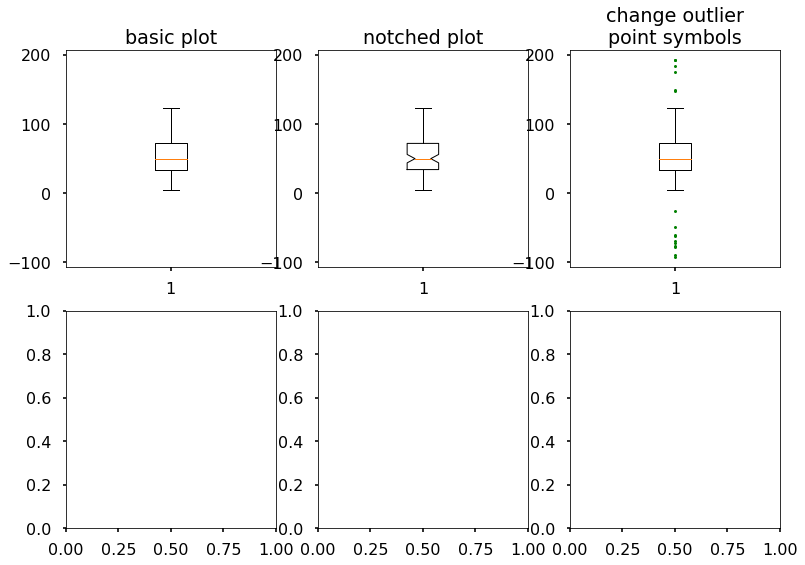

In [1220]:
from matplotlib.patches import Polygon


# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))

fig, axs = plt.subplots(2, 3)

# basic plot
axs[0, 0].boxplot(data)
axs[0, 0].set_title('basic plot')

# notched plot
axs[0, 1].boxplot(data, 1)
axs[0, 1].set_title('notched plot')

# change outlier point symbols
axs[0, 2].boxplot(data, 0, 'g.')
axs[0, 2].set_title('change outlier\npoint symbols')


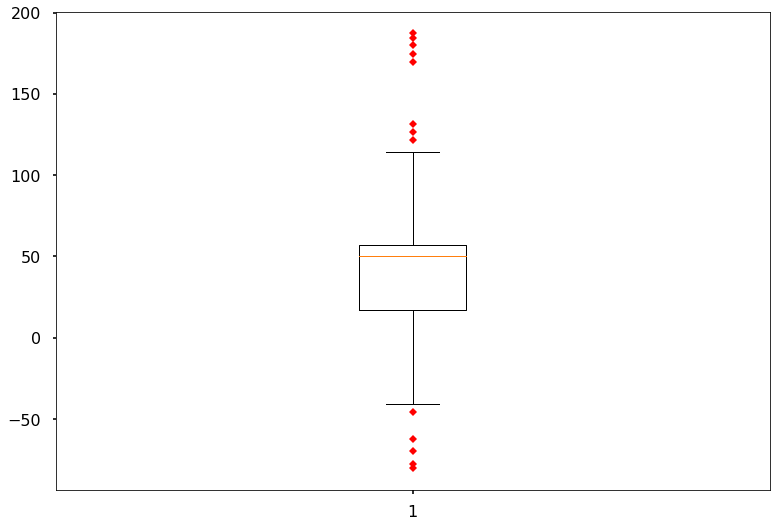

In [1301]:
from pylab import *
spread= rand(50) * 100
center = ones(25) * 50
flier_high = rand(10) * 100 + 100
flier_low = rand(10) * -100
data =concatenate((spread, center, flier_high, flier_low), 0)
r = boxplot(data, 0, 'rD')
top_points = r["fliers"][0].get_data()[1]
#bottom_points = r["fliers"][2].get_data()[1]
plot(np.ones(len(top_points)), top_points, "+")
plt.show()
#plot(np.ones(len(bottom_points)), bottom_points, "+")